# Multi-label classification -- hybrid loss

In [1]:
%matplotlib inline
%load_ext line_profiler
%load_ext memory_profiler
%load_ext autoreload
%autoreload 2

import os, sys, time
import pickle as pkl
import numpy as np
import pandas as pd

from scipy.optimize import minimize
from scipy.optimize import check_grad
from scipy.special import logsumexp
from scipy.special import expit as sigmoid

from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score, make_scorer, label_ranking_loss

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import seaborn as sns
from joblib import Parallel, delayed

In [2]:
sys.path.append('src')
from evaluate import avgPrecisionK, evaluatePrecision, evaluateF1, evaluateRankingLoss, f1_score_nowarn, calcLoss
from datasets import create_dataset, dataset_names, nLabels_dict

In [3]:
dataset_names

['yeast', 'scene', 'bibtex', 'bookmarks', 'delicious', 'mediamill']

In [4]:
data_ix = 2

In [5]:
dataset_name = dataset_names[data_ix]
nLabels = nLabels_dict[dataset_name]
print(dataset_name, nLabels)

bibtex 159


In [6]:
data_dir = 'data'
SEED = 918273645
fmodel_base = os.path.join(data_dir, 'tph-' + dataset_name + '-base.pkl')
fmodel_prec = os.path.join(data_dir, 'tph-' + dataset_name + '-prec.pkl')
fperf_base = os.path.join(data_dir, 'perf-tph-base.pkl')
fperf_prec = os.path.join(data_dir, 'perf-tph-prec.pkl')

Load dataset.

In [55]:
X_train, Y_train = create_dataset(dataset_name, train_data=True, shuffle=True, random_state=SEED)
X_test,  Y_test  = create_dataset(dataset_name, train_data=False)

In [8]:
#X, Y = create_dataset(dataset_name, train_data=True, shuffle=True, random_state=SEED)
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=31)

Feature normalisation.

In [56]:
X_train_mean = np.mean(X_train, axis=0).reshape((1, -1))
X_train_std = np.std(X_train, axis=0).reshape((1, -1)) + 10 ** (-6)
X_train -= X_train_mean
X_train /= X_train_std
X_test  -= X_train_mean
X_test  /= X_train_std

In [57]:
def print_dataset_info(X_train, Y_train, X_test, Y_test):
    N_train, D = X_train.shape
    K = Y_train.shape[1]
    N_test = X_test.shape[0]
    print('%-45s %s' % ('Number of training examples:', '{:,}'.format(N_train)))
    print('%-45s %s' % ('Number of test examples:', '{:,}'.format(N_test)))
    print('%-45s %s' % ('Number of features:', '{:,}'.format(D)))
    print('%-45s %s' % ('Number of labels:', '{:,}'.format(K)))
    avgK_train = np.mean(np.sum(Y_train, axis=1))
    avgK_test  = np.mean(np.sum(Y_test, axis=1))
    print('%-45s %.3f (%.2f%%)' % ('Average number of positive labels (train):', avgK_train, 100*avgK_train / K))
    print('%-45s %.3f (%.2f%%)' % ('Average number of positive labels (test):', avgK_test, 100*avgK_test / K))
    #print('%-45s %.4f%%' % ('Average label occurrence (train):', np.mean(np.sum(Y_train, axis=0)) / N_train))
    #print('%-45s %.4f%%' % ('Average label occurrence (test):', np.mean(np.sum(Y_test, axis=0)) / N_test))
    print('%-45s %.3f%%' % ('Sparsity (percent) (train):', 100 * np.sum(Y_train) / np.prod(Y_train.shape)))
    print('%-45s %.3f%%' % ('Sparsity (percent) (test):', 100 * np.sum(Y_test) / np.prod(Y_test.shape)))

In [58]:
print('%-45s %s' % ('Dataset:', dataset_name))
print_dataset_info(X_train, Y_train, X_test, Y_test)

Dataset:                                      bibtex
Number of training examples:                  4,880
Number of test examples:                      2,515
Number of features:                           1,836
Number of labels:                             159
Average number of positive labels (train):    2.380 (1.50%)
Average number of positive labels (test):     2.444 (1.54%)
Sparsity (percent) (train):                   1.497%
Sparsity (percent) (test):                    1.537%


Approximate `max()` using `log-sum-exp()`.

In [12]:
%%script false
xs = np.random.rand(500000).reshape(10, 50000) * np.arange(1, 11)[:, None]
maxes = np.max(xs, axis=1)
print(xs.shape)
print(maxes.shape)

#rs = np.array([0.5, 1, 2, 4, 8, 16, 32, 64])
rs = np.array([4, 8, 16, 32, 64])
mses = []
for r in rs:
    approx = []
    for i in range(xs.shape[0]):
        approx.append(np.log(np.sum(np.exp(r * xs[i, :]))) / r)
    deltas = np.array(approx) - maxes
    mses.append(np.dot(deltas, deltas))

#fig = plt.Figure(figsize=[20, 12])
plt.plot(rs, mses, ls='--', marker='o', c='r')

## top-push loss

Multi-label learning with top push loss.

In [13]:
def obj_toppush_example(w, X, Y, r=1, weighting=True):
    """
        Objective of top push loss for examples
        
        Input:
            - w: current weight vector, flattened L x D
            - X: feature matrix, N x D
            - Y: label matrix,   N x K
            - r: parameter for log-sum-exp approximation
            - weighting: if True, divide K+ in top-push loss
    """
    N, D = X.shape
    K = Y.shape[1]
    assert(w.shape[0] == K * D)
    assert(r > 0)
    
    W = w.reshape(K, D)  # theta
    
    J = 0.0  # cost
    G = np.zeros_like(W)  # gradient matrix
    
    # instead of using diagonal matrix to scale each row of a matrix with a different factor,
    # we use Mat * Vec[:, None] which is more memory efficient
    
    if weighting is True:
        KPosAll = np.sum(Y, axis=1)  # number of positive labels for each example, N by 1
    else:
        KPosAll = np.ones(N)
        
    A_diag = 1.0 / KPosAll
    AY = Y * A_diag[:, None]
    
    T1 = np.dot(X, W.T)  # N by K
    #m0 = np.max(T1)  # underflow in np.exp(r*T1 - m1)
    m0 = 0.5 * (np.max(T1) + np.min(T1))
    m1 = r * m0
    #print('----------------')
    #print(np.min(T1), np.max(T1), m0)
    #print(np.min(r*T1), np.max(r*T1), m1)
    #print(np.min(r * T1 - m1), np.max(r * T1 - m1))
    T2 = np.multiply(1 - Y, np.exp(r * T1 - m1))  # N by K
    B_tilde_diag = np.dot(T2, np.ones(K))
    #print(np.max(B_tilde_diag), np.min(B_tilde_diag))  # big numbers here, can cause overflow in T3
    
    #T3 = np.exp(-T1 + m0) * np.power(B_tilde_diag, 1.0 / r)[:, None]
    #T4 = np.multiply(AY, np.log1p(T3))
    T3 = (-T1 + m0) + (1.0 / r) * np.log(B_tilde_diag)[:, None]
    #print(np.min(T3), np.max(T3))
    m2 = 0.5 * (np.min(T3) + np.max(T3))
    #T4 = np.logaddexp(0, T3)
    T4 = np.logaddexp(-m2, T3-m2) + m2
    T5 = np.multiply(AY, T4)  
    
    #J = np.dot(w, w) * 0.5 / C + np.dot(np.ones(N), np.dot(T5, np.ones(K))) / N
    J = np.dot(np.ones(N), np.dot(T5, np.ones(K))) / N
    
    #T5 = 1.0 / (1.0 + np.divide(1.0, T3))
    #T5 = np.divide(T3, 1 + T3)
    T6 = np.exp(T3 - T4)
    O_diag = np.dot(np.multiply(Y, T6), np.ones(K))
    T7 = A_diag * (1.0 / B_tilde_diag) * O_diag
    
    G1 = np.dot(np.multiply(AY, T6).T, -X)
    
    #print(np.max(T2), np.min(T2), np.max(T7), np.min(T7))
    T8 = T2 * T7[:, None]
    G2 = np.dot(T8.T, X)
    
    #G = W / C + (G1 + G2) / N
    G = (G1 + G2) / N
    
    return (J, G.ravel())

In [14]:
def obj_toppush_example_loop(w, X, Y, r=1, weighting=True):
    """
        Objective of top push loss for examples
        
        Input:
            - w: current weight vector, flattened L x D
            - X: feature matrix, N x D
            - Y: label matrix,   N x K
            - C: regularisation constant, C = 1 / lambda
            - r: parameter for log-sum-exp approximation
    """
    N, D = X.shape
    K = Y.shape[1]
    assert(w.shape[0] == K * D)
    assert(r > 0)
    
    W = w.reshape(K, D)  # theta
    
    J = 0.0  # cost
    G = np.zeros_like(W)  # gradient matrix
    if weighting is True:
        KPosAll = np.sum(Y, axis=1)  # number of positive labels for each example, N by 1
    else:
        KPosAll = np.ones(N)
    
    for n in range(N):
        for k in range(K):
            if Y[n, k] == 1:
                s1 = np.sum([np.exp(r * np.dot(W[j, :] - W[k, :], X[n, :])) for j in range(K) if Y[n, j] == 0])
                J += np.log1p(np.power(s1, 1.0 / r)) / KPosAll[n]
    #J = np.dot(w, w) * 0.5 / C + J / N
    J = J / N
    
    for k in range(K):
        for n in range(N):
            if Y[n, k] == 1:
                t1 = np.sum([np.exp(r * np.dot(W[j, :] - W[k, :], X[n, :])) for j in range(K) if Y[n, j] == 0])
                t2 = -1.0 / (1 + np.power(t1, -1.0 / r))
                G[k, :] = G[k, :] + X[n, :] * t2 / KPosAll[n]
            else:
                sk = 0.0
                for k1 in range(K):
                    if Y[n, k1] == 1:
                        t3 = np.sum([np.exp(r * np.dot(W[j,:] - W[k1, :], X[n, :])) \
                                     for j in range(K) if Y[n, j] == 0])
                        t4 = np.exp(r * np.dot(W[k, :] - W[k1, :], X[n, :]))
                        sk += t4 / (np.power(t3, 1.0 - 1.0 / r) + t3)
                G[k, :] = G[k, :] + X[n, :] * sk / KPosAll[n]
                        
    #G = W / C + G / N
    G = G / N
    
    return (J, G.ravel())

In [15]:
def obj_toppush_label_loop(w, X, Y, r=1, weighting=True):
    """
        Objective of top push loss for each label
        
        Input:
            - w: current weight vector, flattened L x D
            - X: feature matrix, N x D
            - Y: label matrix,   N x K
            - r1: parameter for log-sum-exp approximation
    """
    N, D = X.shape
    K = Y.shape[1]
    assert(w.shape[0] == K * D)
    assert(r > 0)
    
    W = w.reshape(K, D)  # theta
    
    J = 0.0  # cost
    G = np.zeros_like(W)  # gradient matrix
    if weighting is True:
        NPosAll = np.sum(Y, axis=0)  # number of positive examples for each label, K by 1
    else:
        NPosAll = np.ones(K)
    
    for k in range(K):
        Jk = 0.0
        posInd = np.nonzero(Y[:, k])[0].tolist()
        negInd = sorted(set(np.arange(N).tolist()) - set(posInd))
        for p in posInd:
            t1 = np.sum([np.exp(r * np.dot(W[k, :], X[q, :] - X[p, :])) for q in negInd])
            Jk += np.log1p(np.power(t1, 1.0/r))
            #t1 = -np.dot(W[k, :], X[p, :]) + logsumexp([r * np.dot(W[k, :], X[q, :]) for q in negInd]) / r
            #Jk += np.logaddexp(0, t1)
            t2 = np.power(t1, 1.0-1.0/r) + t1
            vk = np.zeros(D)
            for q in negInd:
                vk = vk + np.exp(r * np.dot(W[k, :], X[q, :] - X[p, :])) * (X[q, :] - X[p, :])
            G[k, :] = G[k, :] + vk / t2
        J += Jk / NPosAll[k]
        G[k, :] = G[k, :] / NPosAll[k]
        
    J = J / K
    G = G / K
        
    return (J, G.ravel())

In [16]:
def obj_toppush_example(w, X, Y, r=1, weighting=True):
    """
        Objective of top push loss for examples
        
        Input:
            - w: current weight vector, flattened L x D
            - X: feature matrix, N x D
            - Y: label matrix,   N x K
            - r: parameter for log-sum-exp approximation
            - weighting: if True, divide K+ in top-push loss
    """
    N, D = X.shape
    K = Y.shape[1]
    assert(w.shape[0] == K * D)
    assert(r > 0)
    
    W = w.reshape(K, D)  # theta
    
    J = 0.0  # cost
    G = np.zeros_like(W)  # gradient matrix
    
    # instead of using diagonal matrix to scale each row of a matrix with a different factor,
    # we use Mat * Vec[:, None] which is more memory efficient
    
    if weighting is True:
        KPosAll = np.sum(Y, axis=1)  # number of positive labels for each example, N by 1
    else:
        KPosAll = np.ones(N)
        
    A_diag = 1.0 / KPosAll
    AY = Y * A_diag[:, None]
    
    T1 = np.dot(X, W.T)  # N by K
    #m0 = np.max(T1)  # underflow in np.exp(r*T1 - m1)
    m0 = 0.5 * (np.max(T1) + np.min(T1))
    m1 = r * m0
    #print('----------------')
    #print(np.min(T1), np.max(T1), m0)
    #print(np.min(r*T1), np.max(r*T1), m1)
    #print(np.min(r * T1 - m1), np.max(r * T1 - m1))
    T2 = np.multiply(1 - Y, np.exp(r * T1 - m1))  # N by K
    B_tilde_diag = np.dot(T2, np.ones(K))
    #print(np.max(B_tilde_diag), np.min(B_tilde_diag))  # big numbers here, can cause overflow in T3
    
    #T3 = np.exp(-T1 + m0) * np.power(B_tilde_diag, 1.0 / r)[:, None]
    #T4 = np.multiply(AY, np.log1p(T3))
    T3 = (-T1 + m0) + (1.0 / r) * np.log(B_tilde_diag)[:, None]
    #print(np.min(T3), np.max(T3))
    m2 = 0.5 * (np.min(T3) + np.max(T3))
    #T4 = np.logaddexp(0, T3)
    T4 = np.logaddexp(-m2, T3-m2) + m2
    T5 = np.multiply(AY, T4)  
    
    #J = np.dot(w, w) * 0.5 / C + np.dot(np.ones(N), np.dot(T5, np.ones(K))) / N
    J = np.dot(np.ones(N), np.dot(T5, np.ones(K))) / N
    
    #T5 = 1.0 / (1.0 + np.divide(1.0, T3))
    #T5 = np.divide(T3, 1 + T3)
    T6 = np.exp(T3 - T4)
    O_diag = np.dot(np.multiply(Y, T6), np.ones(K))
    T7 = A_diag * (1.0 / B_tilde_diag) * O_diag
    
    G1 = np.dot(np.multiply(AY, T6).T, -X)
    
    #print(np.max(T2), np.min(T2), np.max(T7), np.min(T7))
    T8 = T2 * T7[:, None]
    G2 = np.dot(T8.T, X)
    
    #G = W / C + (G1 + G2) / N
    G = (G1 + G2) / N
    
    return (J, G.ravel())

In [17]:
def obj_toppush_label(w, X, Y, r=1, weighting=True):
    """
        Objective with top push loss for labels
        
        Input:
            - w: current weight vector, flattened L x D
            - X: feature matrix, N x D
            - Y: label matrix,   N x K
            - r: parameter for log-sum-exp approximation
            - weighting: if True, divide N+ in top-push loss
    """
    N, D = X.shape
    K = Y.shape[1]
    assert(w.shape[0] == K * D)
    assert(r > 0)
    
    W = w.reshape(K, D)  # theta
    
    J = 0.0  # cost
    G = np.zeros_like(W)  # gradient matrix
    
    # instead of using diagonal matrix to scale each row of a matrix with a different factor,
    # we use Mat * Vec[:, None] which is more memory efficient
    
    if weighting is True:
        NPosAll = np.sum(Y, axis=0)  # number of positive examples for each label, K by 1
    else:
        NPosAll = np.ones(K)
    P_diag = 1.0 / NPosAll
        
    T1 = np.dot(X, W.T)  # N by K
    T11 = np.multiply(1-Y, T1)
    m0 = 0.5 * (np.max(T11) + np.min(T11))
    m1 = r * m0
    #print(np.max(T11), np.min(T11))
    Q_diag = np.dot(np.ones(N), np.multiply(1-Y, np.exp(r*T11-m1)))  # K by 1
    Q1 = np.power(Q_diag, 1/r)  # K by 1
    T2 = np.multiply(np.exp(-T1+m0), Y).T * Q1[:, None]  # K by N
    T3 = np.log1p(T2) * P_diag[:, None]     # K by N
    J = np.dot(np.dot(np.ones(N), T3.T), np.ones(K)) / K
    
    Denom = np.multiply(Y, np.exp(T1-m0)).T * np.divide(1, Q1)[:, None] + 1  # K by N
    T4 = np.einsum('nk,nk->k', 1-Y, np.exp(r*T11-m1))  # K by 1
    T5 = np.multiply(1-Y, np.exp(r*T11-m1))  # N by K
    T6 = np.dot(T5.T, X)  # K by D
    T7 = T6 * np.divide(1, T4)[:, None]  # K by D
    T8 = np.einsum('nk,nk->k', Y, np.divide(1, Denom).T)  # K by 1
    G1 = T7 * T8[:, None]  # K by D
    
    T9 = np.multiply(Y, np.divide(1, Denom).T)  # N by K
    G2 = np.dot(T9.T, X)  # K by D
    
    G = (G1 - G2) * P_diag[:, None] / K
    
    return (J, G.ravel())

In [18]:
#w0 = 0.001 * np.random.randn(Y_train.shape[1] * X_train.shape[1])
#check_grad(lambda w: obj_toppush_label(w, X_train, Y_train, r=4)[0], 
#           lambda w: obj_toppush_label(w, X_train, Y_train, r=4)[1], w0)

In [19]:
def cmp_loop_vec(func_loop, func_vec, X_train, Y_train, r=4):
    print('%15s %15s %15s %15s %15s' % ('C','J_Diff', 'J_loop', 'J_vec', 'G_Diff'))
    w0 = 0.001 * np.random.randn(Y_train.shape[1] * X_train.shape[1])
    for e in range(-6, 10):
        C = 10**(e)
        #w0 = init_var(X_train, Y_train)
        J,  G  = func_loop(w0, X_train, Y_train)#, r=r)
        J1, G1 = func_vec(w0, X_train, Y_train)#, r=r)
        Gdiff = G1 - G
        #print('%-15g %-15g %-15g' % (J1 - J, J, J1))
        print('%15g %15g %15g %15g %15g' % (C, J1 - J, J, J1, np.dot(Gdiff, Gdiff)))

In [20]:
def check_grad_loop(func, X_train, Y_train, r=4):
    w0 = 0.001 * np.random.randn(Y_train.shape[1] * X_train.shape[1])
    eps = 1.49e-08
    w = np.zeros_like(w0)
    for i in range(len(w0)):
        sys.stdout.write('\r%d / %d' % (i+1, len(w0)))
        wi1 = w0.copy()
        wi2 = w0.copy()
        wi1[i] = wi1[i] - eps
        wi2[i] = wi2[i] + eps
        J1, _ = func(wi1, X_train, Y_train, r=r)
        J2, _ = func(wi2, X_train, Y_train, r=r)
        w[i] = (J2 - J1) / (2 * eps)
        #print(w[i])
    J, w1 = obj_toppush_loop(w0, X_train, Y_train, C)
    diff = w1 - w
    return np.sqrt(np.dot(diff, diff))

In [21]:
#cmp_loop_vec(obj_toppush_label_loop, obj_toppush_label, X_train, Y_train)

In [22]:
#check_grad_loop(obj_toppush_label_loop, X_train, Y_train)

In [23]:
#w0 = 0.001 * np.random.randn(Y_train.shape[1] * X_train.shape[1])
#check_grad(lambda w: obj_toppush_label_loop(w, X_train, Y_train, r=4)[0], 
#           lambda w: obj_toppush_label_loop(w, X_train, Y_train, r=4)[1], w0)

In [24]:
def obj_xentropy(w, X, Y, weighting=True, ignorePos=False):
    """
    Objective with logistic loss
    
    Input:
            - w: current weight vector, flattened K x D
            - X: feature matrix, N x D
            - Y: label matrix,   N x K
    """
    N, D = X.shape
    K = Y.shape[1]
    assert(w.shape[0] == K * D)
        
    W = w.reshape(K, D)  # theta
    if weighting is True:
        NK = N * K
    else:
        NK = N
    
    J = 0.0  # cost
    G = np.zeros_like(W)  # gradient matrix
    
    T1 = np.dot(W, X.T)  # K by N
    T2 = np.exp(T1)
    T3 = np.divide(T2, 1+T2)
    T4 = np.log1p(T2)
    T5 = np.log1p(np.divide(1.0, T2))
    T6 = np.multiply(Y.T, T5-T4)
    if not ignorePos:
        T7 = T4 + T6  # K by N
    else:
        T7 = T6
    
    J = np.dot(np.ones(K), np.dot(T7, np.ones(N))) / NK
    
    if not ignorePos:
        G = np.dot(T3-Y.T, X) / NK
    else:
        G = np.dot(-Y.T, X) / NK
    
    return (J, G.ravel())

In [25]:
def obj_xentropy_loop(w, X, Y, weighting=True, ignorePos=False):
    """
    Objective with logistic loss
    
    Input:
            - w: current weight vector, flattened K x D
            - X: feature matrix, N x D
            - Y: label matrix,   N x K
    """    
    N, D = X.shape
    K = Y.shape[1]
    assert(w.shape[0] == K * D)
        
    W = w.reshape(K, D)  # theta
    if weighting is True:
        NK = N * K
    else:
        NK = N
    
    J = 0.0  # cost
    G = np.zeros_like(W)  # gradient matrix
    
    for k in range(K):
        for n in range(N):
            t1 = np.exp(np.dot(W[k, :], X[n, :]))
            t2 = np.log1p(t1)
            if not ignorePos:
                J += t2
            if Y[n, k] == 1:
                J += (np.log1p(1.0 / t1) - t2)
            if not ignorePos:
                G[k, :] = G[k, :] + X[n, :] * (t1 / (1 + t1) - Y[n, k])
            else:
                G[k, :] = G[k, :] + X[n, :] * (-Y[n, k])
                
    J = J / NK
    G = G / NK
    
    return (J, G.ravel())

In [26]:
#w0 = 0.001 * np.random.randn(Y_train.shape[1] * X_train.shape[1])
#check_grad(lambda w: obj_xentropy(w, X_train, Y_train, ignorePos=True)[0], 
#           lambda w: obj_xentropy(w, X_train, Y_train, ignorePos=True)[1], w0)

In [27]:
#cmp_loop_vec(obj_xentropy_loop, obj_xentropy, X_train, Y_train)

In [28]:
def obj_hybrid_TP_LR(w, X, Y, C, C1, r=8, weighting=True):
    """
    Objective with L2 regularisation and top push loss
    """
    
    assert C > 0
    assert C1 > 0
    assert r > 0
    
    J1, G1 = obj_toppush_example(w, X, Y, r, weighting)
    J2, G2 = obj_xentropy(w, X, Y)
    
    J = np.dot(w, w) * 0.5 / C + J1 + C1 * J2
    G = w / C + G1 + C1 * G2
    
    return (J, G)

In [29]:
def obj_hybrid_TP_LR2(w, X, Y, C, C1, r=8, weighting=True):
    """
    Objective with L2 regularisation and top push loss
    """
    
    assert C > 0
    assert C1 > 0
    assert r > 0
    
    J1, G1 = obj_toppush_example(w, X, Y, r, weighting)
    J2, G2 = obj_xentropy(w, X, Y, ignorePos=True)
    
    J = np.dot(w, w) * 0.5 / C + J1 + C1 * J2
    G = w / C + G1 + C1 * G2
    
    return (J, G)

In [30]:
def obj_hybrid_TP_TP(w, X, Y, C, C1=1, r=8, weighting=True):
    """
    Objective with L2 regularisation and top push loss
    """
    
    assert C > 0
    assert C1 > 0
    assert r > 0
    
    J1, G1 = obj_toppush_example(w, X, Y, r, weighting)
    J2, G2 = obj_toppush_label(w, X, Y, r, weighting)
    
    J = np.dot(w, w) * 0.5 / C + J1 + C1 * J2
    G = w / C + G1 + C1 * G2
    
    return (J, G)

In [31]:
def obj_hybrid_LR_TP(w, X, Y, C, C1=1, r=8, weighting=True):
    """
    Objective with L2 regularisation and top push loss
    """
    
    assert C > 0
    assert C1 > 0
    assert r > 0
    
    J1, G1 = obj_xentropy(w, X, Y)
    J2, G2 = obj_toppush_label(w, X, Y, r, weighting)
    
    J = np.dot(w, w) * 0.5 / C + J1 + C1 * J2
    G = w / C + G1 + C1 * G2
    
    return (J, G)

Check gradient

In [32]:
%%script false
#X_train = X_train[:50, :]
#Y_train = Y_train[:50, :]
C = 1
C1 = 1
w0 = 0.001 * np.random.randn(Y_train.shape[1] * X_train.shape[1])
#obj_func = obj_hybrid_TP_LR
#obj_func = obj_hybrid_TP_TP
#obj_func = obj_hybrid_LR_TP
obj_func = obj_hybrid_TP_LR2

check_grad(lambda w: obj_func(w, X_train, Y_train, C, C1, r=8)[0], 
           lambda w: obj_func(w, X_train, Y_train, C, C1, r=8)[1], w0)

In [33]:
class MLC_hybrid(BaseEstimator):
    """All methods are necessary for a scikit-learn estimator"""
    
    def __init__(self, C=1, C1=1, r=1, weighting=True):
        """Initialisation"""
        
        assert C > 0
        assert C1 > 0
        assert r > 0
        assert type(weighting) == bool
        self.C = C
        self.C1 = C1
        self.r = r
        self.weighting = weighting
        #self.obj_func = obj_hybrid_TP_LR
        #self.obj_func = obj_hybrid_LR_TP
        #self.obj_func = obj_hybrid_TP_TP
        self.obj_func = obj_hybrid_TP_LR2
        self.trained = False
        
    def fit(self, X_train, Y_train):
        """Model fitting by optimising the objective"""
        opt_method = 'L-BFGS-B' #'BFGS' #'Newton-CG'
        options = {'disp': 1, 'maxiter': 10**5, 'maxfun': 10**5} # , 'iprint': 99}
        print('\nC: %g, C1: %g, r: %g, weighting: %s' % (self.C, self.C1, self.r, self.weighting))
            
        N, D = X_train.shape
        K = Y_train.shape[1]
        #w0 = np.random.rand(K * D) - 0.5  # initial guess in range [-1, 1]
        w0 = 0.001 * np.random.randn(K * D)
        opt = minimize(self.obj_func, w0, args=(X_train, Y_train, self.C, self.C1, self.r, self.weighting), \
                       method=opt_method, jac=True, options=options)
        if opt.success is True:
            self.W = np.reshape(opt.x, (K, D))
            self.trained = True
        else:
            sys.stderr.write('Optimisation failed')
            print(opt.items())
            self.trained = False
            
            
    def decision_function(self, X_test):
        """Make predictions (score is real number)"""
        
        assert self.trained is True, "Can't make prediction before training"
        D = X_test.shape[1]
        return np.dot(X_test, self.W.T)
        
    
    def predict(self, X_test):
        return self.decision_function(X_test)
    #    """Make predictions (score is boolean)"""   
    #    preds = sigmoid(self.decision_function(X_test))
    #    #return (preds >= 0)
    #    assert self.TH is not None
    #    return preds >= self.TH        
        
    # inherit from BaseEstimator instead of re-implement
    #
    #def get_params(self, deep = True):
    #def set_params(self, **params):

In [34]:
def dump_results(predictor, X_train, Y_train, X_test, Y_test, fname, rankingLoss=False):
    """
        Compute and save performance results
    """
    preds_train = predictor.decision_function(X_train)
    preds_test  = predictor.decision_function(X_test)
    
    print('Training set:')
    perf_dict_train = evaluatePrecision(Y_train, preds_train, verbose=1)
    print()
    print('Test set:')
    perf_dict_test = evaluatePrecision(Y_test, preds_test, verbose=1)
    
    if rankingLoss is True:
        print()
        print('Training set:')
        perf_dict_train.update(evaluateRankingLoss(Y_train, preds_train))
        print(label_ranking_loss(Y_train, preds_train))
        print()
        print('Test set:')
        perf_dict_test.update(evaluateRankingLoss(Y_test, preds_test))
        print(label_ranking_loss(Y_test, preds_test))

    # compute F1 score w.r.t. different thresholds
    #TH1 = predictor.cv_results_['mean_test_TH'][clf.best_index_]
    #TH2 = np.mean(Y_train, axis=0)
    #TH3 = np.mean(TH2)
    
    #preds_train_bin = sigmoid(preds_train)
    #preds_test_bin  = sigmoid(preds_test)
    
    #F1_train1 = f1_score_nowarn(Y_train, sigmoid(preds_train) >= TH1, average='samples')
    #F1_test1  = f1_score_nowarn(Y_test, sigmoid(preds_test) >= TH1, average='samples')
    #print('\nTrain: %.4f, %f' % (F1_train1, f1_score(Y_train, sigmoid(preds_train) >= TH1, average='samples')))
    #print('\nTest : %.4f, %f' % (F1_test1, f1_score(Y_test, sigmoid(preds_test) >= TH1, average='samples')))
    
    #F1_train2 = f1_score_nowarn(Y_train, (preds_train_bin - TH2) >= 0, average='samples')
    #F1_test2  = f1_score_nowarn(Y_test, (preds_test_bin - TH2) >= 0, average='samples')
    #print('\nTrain: %.4f, %f' % (F1_train2, f1_score(Y_train, (preds_train_bin - TH2) >= 0, average='samples')))
    #print('\nTest : %.4f, %f' % (F1_test2, f1_score(Y_test, (preds_test_bin - TH2) >= 0, average='samples')))
    
    #F1_train3 = f1_score_nowarn(Y_train, preds_train_bin >= TH3, average='samples')
    #F1_test3  = f1_score_nowarn(Y_test, preds_test_bin >= TH3, average='samples')
    #print('\nTrain: %.4f, %f' % (F1_train3, f1_score(Y_train, preds_train_bin >= TH3, average='samples')))
    #print('\nTest : %.4f, %f' % (F1_test3, f1_score(Y_test, preds_test_bin >= TH3, average='samples')))
    
    #perf_dict_train.update({'F1': [(F1_train1,), (F1_train2,), (F1_train3,)]})
    #perf_dict_test.update( {'F1': [(F1_test1,),  (F1_test2,),  (F1_test3,)]})
    #perf_dict_train.update({'F1': [(F1_train2,), (F1_train3,)]})
    #perf_dict_test.update( {'F1': [(F1_test2,),  (F1_test3,)]})
    
    perf_dict = {'Train': perf_dict_train, 'Test': perf_dict_test}
    if os.path.exists(fname):
        _dict = pkl.load(open(fname, 'rb'))
        if dataset_name not in _dict:
            _dict[dataset_name] = perf_dict
    else:
        _dict = {dataset_name: perf_dict}
    pkl.dump(_dict, open(fname, 'wb'))
    
    print()
    print(pkl.load(open(fname, 'rb')))

In [35]:
old_settings = np.seterr(all='ignore')  # seterr to known value
np.seterr(all='raise')
#np.seterr(all='ignore')
#np.seterr(**old_settings)  # restore settings

{'divide': 'ignore', 'invalid': 'ignore', 'over': 'ignore', 'under': 'ignore'}

In [36]:
#%memit model.fit(X_train[:30], Y_train[:30])
#%mprun -f minimize model.fit(X_train[:100], Y_train[:100])
#%mprun -f _minimize_slsqp model.fit(X_train[:10], Y_train[:10])

Default model.

In [37]:
%%script false
if os.path.exists(fmodel_base):
    clf = pkl.load(open(fmodel_base, 'rb'))
else:
    clf = clf = MLC_hybrid()
    clf.fit(X_train, Y_train)
    pkl.dump(clf, open(fmodel_base, 'wb'))

In [38]:
#dump_results(clf, X_train, Y_train, X_test, Y_test, fperf_base)

Cross validation w.r.t. average precision@K.

In [39]:
#ranges = range(-6, 7)
#ranges = range(-6, 5)
#parameters = [{'C': sorted([10**(e) for e in ranges] + [3 * 10**(e) for e in ranges]),
parameters = [{'C': [1e-3, 3e-3, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300],#, 1e3],
               'C1': [0.5, 1, 2],
               'r': [8],
               'weighting': [True, False],
              }]
scorer = {'Prec': make_scorer(avgPrecisionK)}

In [40]:
#fmodel_prec = os.path.join(data_dir, 'tph-' + dataset_name + '-tp-lr2.pkl')

In [41]:
if not os.path.exists(fmodel_prec):
    clf = GridSearchCV(MLC_hybrid(), parameters, scoring=scorer, cv=5, n_jobs=1, refit='Prec')
    clf.fit(X_train, Y_train)
    #pkl.dump(clf, open(fmodel_prec, 'wb'))
else:
    clf = pkl.load(open(fmodel_prec, 'rb'))


C: 0.001, C1: 0.5, r: 8, weighting: True

C: 0.001, C1: 0.5, r: 8, weighting: True

C: 0.001, C1: 0.5, r: 8, weighting: True

C: 0.001, C1: 0.5, r: 8, weighting: True

C: 0.001, C1: 0.5, r: 8, weighting: True

C: 0.001, C1: 0.5, r: 8, weighting: False

C: 0.001, C1: 0.5, r: 8, weighting: False

C: 0.001, C1: 0.5, r: 8, weighting: False

C: 0.001, C1: 0.5, r: 8, weighting: False

C: 0.001, C1: 0.5, r: 8, weighting: False

C: 0.001, C1: 1, r: 8, weighting: True

C: 0.001, C1: 1, r: 8, weighting: True

C: 0.001, C1: 1, r: 8, weighting: True

C: 0.001, C1: 1, r: 8, weighting: True

C: 0.001, C1: 1, r: 8, weighting: True

C: 0.001, C1: 1, r: 8, weighting: False

C: 0.001, C1: 1, r: 8, weighting: False

C: 0.001, C1: 1, r: 8, weighting: False

C: 0.001, C1: 1, r: 8, weighting: False

C: 0.001, C1: 1, r: 8, weighting: False

C: 0.001, C1: 2, r: 8, weighting: True

C: 0.001, C1: 2, r: 8, weighting: True

C: 0.001, C1: 2, r: 8, weighting: True

C: 0.001, C1: 2, r: 8, weighting: True

C: 0.001,


C: 1, C1: 2, r: 8, weighting: False

C: 1, C1: 2, r: 8, weighting: False

C: 1, C1: 2, r: 8, weighting: False

C: 1, C1: 2, r: 8, weighting: False

C: 3, C1: 0.5, r: 8, weighting: True

C: 3, C1: 0.5, r: 8, weighting: True

C: 3, C1: 0.5, r: 8, weighting: True

C: 3, C1: 0.5, r: 8, weighting: True

C: 3, C1: 0.5, r: 8, weighting: True

C: 3, C1: 0.5, r: 8, weighting: False

C: 3, C1: 0.5, r: 8, weighting: False

C: 3, C1: 0.5, r: 8, weighting: False

C: 3, C1: 0.5, r: 8, weighting: False

C: 3, C1: 0.5, r: 8, weighting: False

C: 3, C1: 1, r: 8, weighting: True

C: 3, C1: 1, r: 8, weighting: True

C: 3, C1: 1, r: 8, weighting: True

C: 3, C1: 1, r: 8, weighting: True

C: 3, C1: 1, r: 8, weighting: True

C: 3, C1: 1, r: 8, weighting: False

C: 3, C1: 1, r: 8, weighting: False

C: 3, C1: 1, r: 8, weighting: False

C: 3, C1: 1, r: 8, weighting: False

C: 3, C1: 1, r: 8, weighting: False

C: 3, C1: 2, r: 8, weighting: True

C: 3, C1: 2, r: 8, weighting: True

C: 3, C1: 2, r: 8, weighting:

In [43]:
dump_results(clf, X_train, Y_train, X_test, Y_test, fperf_prec, rankingLoss=True)

Training set:
Average Precision@3: 0.6483, 0.005
Average Precision@5: 0.4448, 0.004
Average Precision@10: 0.2331, 0.002
Average Precision@K: 0.9752, 0.002

Test set:
Average Precision@3: 0.3958, 0.009
Average Precision@5: 0.2859, 0.007
Average Precision@10: 0.1737, 0.004
Average Precision@K: 0.5114, 0.012

Training set:
Average RankingLoss: 1.0784, 0.153
0.00152134586631

Test set:
Average RankingLoss: 27.8924, 1.644
0.0726339483582

{'bibtex': {'Train': {'Precision@3': (0.63934426229508201, 0.004116089338362155), 'Precision@5': (0.43979508196721306, 0.0036297213637683607), 'Precision@10': (0.23174180327868854, 0.0021432623293462356), 'Precision@K': (0.95607687877923542, 0.0022795006116223477), 'RankingLoss': (1.5038934426229509, 0.1477394961812328)}, 'Test': {'Precision@3': (0.39549370444002652, 0.0056192723394597075), 'Precision@5': (0.28882703777335988, 0.0040664892761898943), 'Precision@10': (0.1759840954274354, 0.0024834010761927527), 'Precision@K': (0.51715523525838114, 0.0077593

In [44]:
preds_train = clf.decision_function(X_train)
tploss_train = calcLoss(Y_train, preds_train, 'TopPush', njobs=4)
pak_train = calcLoss(Y_train, preds_train, 'Precision@K', njobs=4)

In [45]:
preds_test = clf.decision_function(X_test)
tploss_test = calcLoss(Y_test, preds_test, 'TopPush', njobs=4)
pak_test = calcLoss(Y_test, preds_test, 'Precision@K', njobs=4)

In [47]:
def plot_loss(loss, pak, title):
    # the data
    x = loss
    y = 1 - pak
    
    print('away from diagonal portion:', np.mean(loss != 1-pak))

    nullfmt = NullFormatter()         # no labels

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]

    # start with a rectangular Figure
    plt.figure(1, figsize=(8, 8))

    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)

    # no labels
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)

    # the scatter plot:
    axScatter.scatter(x, y, color='b', alpha=0.5)
    axScatter.plot([0, 1], [0, 1], ls='--', color='g')
    axScatter.set_xlabel('Top push loss', fontdict={'fontsize': 12})
    axScatter.set_ylabel('1 - precision@K', fontdict={'fontsize': 12})

    # now determine nice limits by hand:
    #binwidth = 0.25
    #xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
    #lim = (int(xymax/binwidth) + 1) * binwidth

    #axScatter.set_xlim((-lim, lim))
    #axScatter.set_ylim((-lim, lim))

    #bins = np.arange(-lim, lim + binwidth, binwidth)

    axHistx.hist(x, bins=10, color='g', alpha=0.3)
    axHistx.set_yscale('log')
    axHisty.hist(y, bins=10, color='g', alpha=0.3, orientation='horizontal')
    axHisty.set_xscale('log')

    #axHistx.set_xlim(axScatter.get_xlim())
    #axHisty.set_ylim(axScatter.get_ylim())

    axHistx.set_title(title, fontdict={'fontsize': 15}, loc='center')

away from diagonal portion: 0.0343237704918


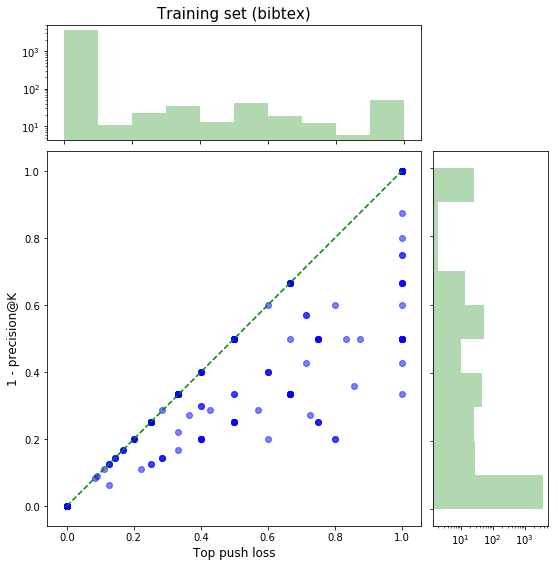

In [48]:
plot_loss(tploss_train, pak_train, 'Training set (' + dataset_name + ')')

In [50]:
tploss_train.shape

(3904,)

In [ ]:
np.mean(tploss_train != 1-pak_train)

In [51]:
tploss_test.shape

(976,)

away from diagonal portion: 0.282786885246


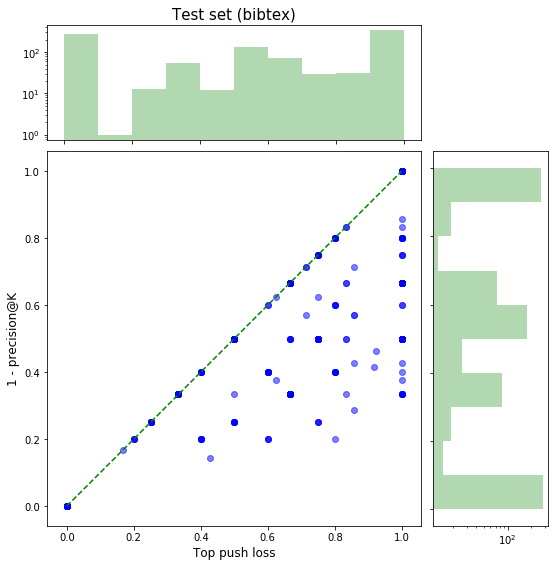

In [49]:
plot_loss(tploss_test, pak_test, 'Test set (' + dataset_name + ')')

In [ ]:
pkl.dump(clf, open(os.path.join(data_dir, 'tph-' + dataset_name + '-tp-lr2.pkl'), 'wb'))

In [52]:
clf = pkl.load(open(os.path.join(data_dir, 'tph-' + dataset_name + '-tp-lr2.pkl'), 'rb'))

In [53]:
clf.best_params_

{'C': 30, 'C1': 2, 'r': 8, 'weighting': True}

In [59]:
dump_results(clf, X_train, Y_train, X_test, Y_test, fperf_prec, rankingLoss=False)

Training set:
Average Precision@3: 0.6464, 0.004
Average Precision@5: 0.4438, 0.004
Average Precision@10: 0.2328, 0.002
Average Precision@K: 0.9691, 0.002

Test set:
Average Precision@3: 0.3928, 0.006
Average Precision@5: 0.2839, 0.004
Average Precision@10: 0.1738, 0.002
Average Precision@K: 0.5132, 0.008

{'bibtex': {'Train': {'Precision@3': (0.63934426229508201, 0.004116089338362155), 'Precision@5': (0.43979508196721306, 0.0036297213637683607), 'Precision@10': (0.23174180327868854, 0.0021432623293462356), 'Precision@K': (0.95607687877923542, 0.0022795006116223477), 'RankingLoss': (1.5038934426229509, 0.1477394961812328)}, 'Test': {'Precision@3': (0.39549370444002652, 0.0056192723394597075), 'Precision@5': (0.28882703777335988, 0.0040664892761898943), 'Precision@10': (0.1759840954274354, 0.0024834010761927527), 'Precision@K': (0.51715523525838114, 0.0077593318677975781), 'RankingLoss': (27.534791252485089, 1.0264545560002458)}}, 'bookmarks': {'Train': {'Precision@3': (0.34539999999999

In [81]:
f1_score_nowarn(Y_test, clf.decision_function(X_test) > 1.09, average='samples')

0.40466389830009836

In [ ]:
clf2 = MLC_hybrid(C=300, C1=2, r=8, weighting=True)
clf2.fit(X_train, Y_train)

In [ ]:
dump_results(clf2, X_train, Y_train, X_test, Y_test, fperf_prec, rankingLoss=False)

In [ ]:
#f1_score_nowarn(Y_test, clf.decision_function(X_test) > 0, average='samples')